# Robustness Noise 
In order to understand the results better from the testing so far, in particular the plots, we want to analyse how noise influences our computations.
This serves the overall goal of improving our method with noisy data.
Following questions arise:

How can we bound the finite difference method?

How stable is the SVD to noise?

We only consider noise which is normally distributed? Does this influence our result?

What is the relation between the highest and the lowest singular value? Do they grow/shrink in a similar way when confronted with noise?

In [1]:
import numpy as np
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise,create_data_2d
import pysindy as ps
import matplotlib.pyplot as plt

## SVD Robustness Noise
There is a theorem and a corollary:

Theorem 2.18 (Mirsky). If $A,E \in K^{IxI}$ are two arbitrary matrices, then $\sqrt{\sum_{k=1}^{r}|\sigma_k(A+E) - \sigma_k(A)|} \leq \lVert E \rVert_F$

Corollary:
If $A,E \in K^{IxI}$ are two arbitrary matrices, then $\forall k \ |\sigma_k(A+E) - \sigma_k(A)| \leq \lVert E \rVert$

#### 1. What is the spectral and Frobenius norm of random noise matrices?

In [2]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -10,10
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
matrix[:, 1] = alpha*matrix[:,2]
print(matrix)

[[-1.00713022 -1.49078647 -7.34648296]
 [-2.57490426  1.18388651  5.83410319]
 [ 6.72693872  0.74694068  3.68086717]
 [-1.01803474 -0.44519269 -2.19387588]
 [ 0.62912969 -1.58649675 -7.818136  ]
 [ 3.68963095 -1.43146907 -7.05417129]
 [-7.05520747 -1.68881758 -8.32236529]
 [ 2.97542329  1.34455031  6.62584224]
 [-3.83342538 -1.32321777 -6.52071707]
 [ 6.35416783 -1.6199709  -7.98309404]]


In [3]:
print(matrix_rank(matrix),svd(matrix, compute_uv=False))
print(np.linalg.norm(matrix))
print(np.linalg.norm(matrix,ord=2))

2 [2.14698256e+01 1.32414683e+01 9.68469855e-16]
25.224787294935215
21.469825595447016


Add noise

In [4]:
#np.random.seed(12)
target_noise=1e-3
var = target_noise * np.sqrt(np.mean(np.square(matrix)))
noise = np.random.normal(0, var, size=matrix.shape)
matrix_noise = matrix + noise
print(f"Added Gaussian noise with variance {var}")

Added Gaussian noise with variance 0.004605395003235245


In [5]:
print("Noise Matrix")
#print(noise)
print(f"Matrix rank: {matrix_rank(noise)}, SVD: {svd(noise, compute_uv=False)}")
print(f"Frobenius norm:\t {np.linalg.norm(noise)}")
print(f"Spectral norm:\t {np.linalg.norm(noise,ord=2)}")

Noise Matrix
Matrix rank: 3, SVD: [0.02047387 0.01824041 0.01111452]
Frobenius norm:	 0.029587573352573494
Spectral norm:	 0.020473869876079638


Print SVD and matrix rank with additional noise

In [6]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t \t matrix rank \t svd \t \t \t \t \t \t \t Frobenius \t \t \t Spectral")
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix + noise
    print(f" {target_noise}      \t \t {matrix_rank(matrix_noise)} \t \t {svd(matrix_noise, compute_uv=False)}     \t {np.linalg.norm(noise)}      \t {np.linalg.norm(noise,ord=2)}")

Noise level 	 	 matrix rank 	 svd 	 	 	 	 	 	 	 Frobenius 	 	 	 Spectral
 0      	 	 2 	 	 [2.14698256e+01 1.32414683e+01 9.68469855e-16]     	 0.0      	 0.0
 1e-10      	 	 3 	 	 [2.14698256e+01 1.32414683e+01 6.58009749e-10]     	 2.412332100142438e-09      	 2.1142842913552525e-09
 1e-09      	 	 3 	 	 [2.14698256e+01 1.32414683e+01 1.16746110e-08]     	 2.4608225035554238e-08      	 1.6282165607953037e-08
 1e-08      	 	 3 	 	 [2.14698257e+01 1.32414683e+01 1.04569412e-07]     	 2.512599900123618e-07      	 1.773085567374942e-07
 1e-07      	 	 3 	 	 [2.14698265e+01 1.32414687e+01 1.86808120e-06]     	 2.896690020479312e-06      	 2.268349842874898e-06
 1e-06      	 	 3 	 	 [2.14698296e+01 1.32414665e+01 1.04462307e-05]     	 3.149960980548693e-05      	 2.45064883746333e-05
 1e-05      	 	 3 	 	 [2.14698765e+01 1.32414897e+01 1.65737195e-04]     	 0.00025171702594210815      	 0.00018358573211045513
 0.0001      	 	 3 	 	 [2.14700336e+01 1.32408393e+01 1.59508887e-03]     	 0.002

Although the Frobenius Norm might not be that high in relation to the highest singular value. In relation to the smallest singular value it can be quite significant. Thus, the changes in the smallest singular value can be more disturbing for our purpose.

#### 2. What is the ratio between the smallest and biggest singular value?

The idea is if $A \in \mathbb{R}^{nxm}$ for $m<n$ has full rank $\frac{\sigma_1}{\sigma_m} < \infty$, but if it does not have full rank $\frac{\sigma_1}{\sigma_m} = \infty$

The bound that we use in the following is for $ \|B\|=max(\frac{1}{\sigma_n},\frac{\sigma_1}{\sigma_n^2}), \ \|B\|_F^2=\frac{1}{\sigma_n}^2+\frac{\sigma_1}{\sigma_n^2}^2$
\begin{equation}
    | \frac{\sigma_1(A+E)}{\sigma_n(A+E)} - \frac{\sigma_1(A)}{\sigma_n(A)} | < \|B\|\|E\|
\end{equation}

In [7]:
#This can be negative and thus is not a correct bound on sv_max/sv_min
def calc_bound_ratio(sv_max,sv_min,noisematrix):
    #E=np.linalg.norm(noisematrix) #Spectral: order=2, Frobenius: default
    B=np.sqrt(1/sv_min+(sv_max/sv_min**2)**2)
    E=np.linalg.norm(noisematrix,ord=2) #Spectral: order=2, Frobenius: default
    #B=max(1/sv_min,sv_max/sv_min**2)
    return E*B

In [8]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -1,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
#matrix = np.random.random(size=(rows,cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
#matrix[:, 1] = matrix[:,2]
#matrix[:,0] = np.random.rand()*matrix[:,2]
#matrix[:, 2] *=1e-6
#matrix[:, 1] *=1e-6
print(matrix)

0.912227678781627
[[ 0.45636972 -0.82765704  0.89417778]
 [-0.33304147 -0.07687073  0.5988271 ]
 [ 0.01009396  0.23508433 -0.55493248]
 [ 0.57949682  0.64868101 -0.68196807]
 [-0.4359575  -0.06269374 -0.30933894]
 [ 0.91782482  0.84207545 -0.38759192]
 [ 0.99421931 -0.82030474 -0.01810039]
 [-0.01438836  0.76469917  0.91437938]
 [-0.58927362  0.72409196 -0.0441453 ]
 [-0.54597093 -0.46827747 -0.87529472]]


In [9]:
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Ratio big/smalles singular value: {sv[0]/sv[-1]}")
print(f"Bound: {calc_bound_ratio(sv_max,sv_min,np.zeros(shape=matrix.shape))}")

matrix shape: (10, 3), rank: 3
Singular values : [2.10537229 1.8302427  1.78942871]
Ratio big/smalles singular value: 1.1765611466374466
Bound: 0.0


In [10]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t sv \t \t \t \t \t \t \t  ratio \t bound")
ratios =[]
bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[0]/sv[-1]
    bound=calc_bound_ratio(sv_max,sv_min,noise)
    ratios.append(np.abs(ratio-sv_max/sv_min))
    bounds.append(bound)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {sv} \t  {ratio:3.3e}  \t {bound:3.3e}")

Noise level 	 matrix rank 	 sv 	 	 	 	 	 	 	  ratio 	 bound
 0	 	 3 	 	 [2.10537229 1.8302427  1.78942871] 	  1.177e+00  	 0.000e+00
 1e-10	 	 3 	 	 [2.10537229 1.8302427  1.78942871] 	  1.177e+00  	 2.129e-10
 1e-09	 	 3 	 	 [2.10537229 1.8302427  1.78942871] 	  1.177e+00  	 2.536e-09
 1e-08	 	 3 	 	 [2.1053723  1.8302427  1.78942871] 	  1.177e+00  	 2.635e-08
 1e-07	 	 3 	 	 [2.10537237 1.83024261 1.78942876] 	  1.177e+00  	 2.150e-07
 1e-06	 	 3 	 	 [2.1053731  1.83024313 1.78942907] 	  1.177e+00  	 2.174e-06
 1e-05	 	 3 	 	 [2.10537241 1.83024345 1.78943184] 	  1.177e+00  	 2.490e-05
 0.0001	 	 3 	 	 [2.10539908 1.83017154 1.78951102] 	  1.177e+00  	 2.353e-04
 0.001	 	 3 	 	 [2.10566005 1.8300877  1.78957722] 	  1.177e+00  	 2.661e-03
 0.01	 	 3 	 	 [2.12055893 1.8299838  1.79480525] 	  1.181e+00  	 2.745e-02
 0.1	 	 3 	 	 [2.05316001 1.90605811 1.75599407] 	  1.169e+00  	 2.485e-01


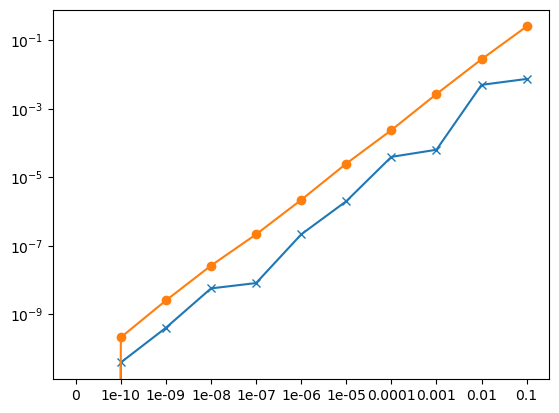

In [11]:
plt.plot(ratios,marker='x')
plt.plot(bounds,marker='o')
plt.xticks(ticks=(np.arange(0,11)),labels=noise_levels)
plt.yscale('log')

Since for matrix with not full rank the bound is very high, I want to test the deviation for the same noise level

In [12]:
trials=10
noise_level=1e-10
differences=[]
bounds=[]
print(f"Noise level:  {noise_level}, Number trials: {trials}, True ratio: {sv_max/sv_min}")
print("Trial \t matrix rank \t sv \t \t \t \t \t \t \t  ratio \t \t bound \t \t \t difference")
for trial in range(trials):
    var = noise_level * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio=sv[0]/sv[-1]
    bound = calc_bound_ratio(sv_max,sv_min,noise)
    bounds.append(bound)
    differences.append(np.abs(ratio-sv_max/sv_min))
    print(f" {trial}\t \t {matrix_rank(matrix_noise)} \t {sv}   \t  {ratio:3.3e}   \t \t {bound:3.3e} \t \t {np.abs(ratio-sv_max/sv_min):3.3e}")

Noise level:  1e-10, Number trials: 10, True ratio: 1.1765611466374466
Trial 	 matrix rank 	 sv 	 	 	 	 	 	 	  ratio 	 	 bound 	 	 	 difference
 0	 	 3 	 [2.10537229 1.8302427  1.78942871]   	  1.177e+00   	 	 2.125e-10 	 	 3.600e-11
 1	 	 3 	 [2.10537229 1.8302427  1.78942871]   	  1.177e+00   	 	 2.617e-10 	 	 2.792e-11
 2	 	 3 	 [2.10537229 1.8302427  1.78942871]   	  1.177e+00   	 	 2.807e-10 	 	 7.082e-12
 3	 	 3 	 [2.10537229 1.8302427  1.78942871]   	  1.177e+00   	 	 2.592e-10 	 	 7.747e-11
 4	 	 3 	 [2.10537229 1.8302427  1.78942871]   	  1.177e+00   	 	 2.313e-10 	 	 1.234e-10
 5	 	 3 	 [2.10537229 1.8302427  1.78942871]   	  1.177e+00   	 	 3.283e-10 	 	 1.470e-11
 6	 	 3 	 [2.10537229 1.8302427  1.78942871]   	  1.177e+00   	 	 2.160e-10 	 	 8.852e-12
 7	 	 3 	 [2.10537229 1.8302427  1.78942871]   	  1.177e+00   	 	 2.085e-10 	 	 1.989e-11
 8	 	 3 	 [2.10537229 1.8302427  1.78942871]   	  1.177e+00   	 	 2.116e-10 	 	 4.198e-11
 9	 	 3 	 [2.10537229 1.8302427  1.78942871]  

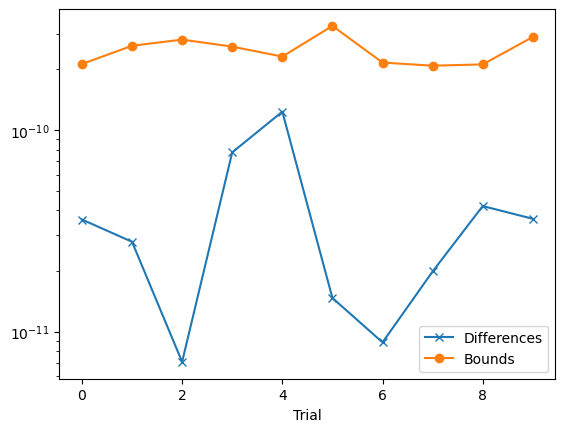

In [13]:
plt.plot(differences,marker='x',label="Differences")
plt.plot(bounds,marker='o',label="Bounds")
plt.yscale('log')
plt.xlabel('Trial')
plt.legend()

## Finite Difference Noise

We can find the coefficients use to calculate the finite differences for different orders in https://en.wikipedia.org/wiki/Finite_difference_coefficient. Calculator https://web.media.mit.edu/~crtaylor/calculator.html<br>
Assuming we have equispaced data for x,and we can bound the measurement error by $\epsilon > 0$ i.e. $||u-\tilde{u}||_{\infty}< \epsilon$ and the third derivative of u
is bounded by $M(t, x) > 0$ on each interval $[x − h, x + h]$. Then, we get tha
$$|u_x(t, x) − \tilde{u}_x(t, x)| ≤ \frac{\epsilon}{h} + \frac{h^2}{6}M(t,x)$$
is the 2nd order centered finite differences approximation of the derivative of $\tilde{u}$.

TODO: error bound for different orders, centered and left-off-centered/backward differences (even/odd order)?<br>
Question: do the same error bounds count at the boundary values of u?? For centered Differences no-> can lead to wron errorbound especially since exp has high values at boundary point

For even order: centered differenced, for uneven order backward differences:<br>
order = 1: <br>
Approximation: $\frac{u(x)-u(x-h)}{h}$,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h}{2}||u'||_{\infty}+\frac{2\epsilon}{h}$ 
<br>
order = 2: <br>
Approximation: $\frac{u(x+\frac{h}{2})-u(x-\frac{h}{2})}{h}$,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h^2}{3}||u^3||_{\infty}+\frac{2\epsilon}{h}$ <br>
(Here we use h/2 since for h the calculation did not work out -> makes more sense???)
order = 4: <br>
Approximation: see book or wiki,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h^4}{30}||u^5||_{\infty}+\frac{9 \epsilon}{6h}$ <br>

In [14]:
from test_data import create_data_2d
experiment_name = "linear_nonunique_1"
n_samples=200
T,X,t,x = create_data_2d(T_start=0, T_end=5, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
#u = np.exp(X-a*T)
#ux = u
#uxx = u
#uxxx = u
#ut = -a*u

u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)
dx=x[1]-x[0]

In [15]:
ux_fd = ps.FiniteDifference(order=3,d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
u_flat, u_x_flat = u.flatten(), ux_fd.flatten()
g= np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
print(g.shape)
print(f"Matrix rank = {matrix_rank(g)}, svd = {svd(g, compute_uv=False)}")

(40000, 2)
Matrix rank = 2, svd = [148.97044547 133.44587997]


### Check difference between noisy derivative and correct derivative

To approximate $\|u'-\tilde{u}'\|$

General formula for central differences: $$ \text{sum over ceofficients} \frac{\epsilon}{h} + h^{order} \|u^{order+1}\|_{\infty}\frac{(order/2)!^2}{(order+1)!}$$

For backward differences: $$ \text{sum over ceofficients}\frac{\epsilon}{h} + h^{order}\|u^{order+1}\|_{\infty} \frac{1}{order+1}$$

Here compute functions for computing lagrange coefficients and sum(for calculating measurment error) 
$$L_{n,k}(x) =\prod_{i=0,i\neq k}^n \frac{x-x_i}{x_k-x_i}$$
$$  L'_{n,k}(x) = [\prod_{i=0,i\neq k}^n \frac{1}{x_k-x_i}] \sum_{j=0,j\neq k}^n \prod_{i=0,i\neq k,j}^n (x-x_i)
  = h^{-1}[\prod_{i=0,i\neq k}^n \frac{1}{k-i}] \sum_{j=0,j\neq k}^n \prod_{i=0,i\neq k,j}^n (l-i) $$
Note here n stands for the order as well

In [16]:
"""
n: number of data points
k: number of lagrange coefficient
l: number of data point where L is evaluated at: x = x_l = x+ hl
"""
#Computes the coefficients of the derivitve of the kth Lagrangian Coefficients
#These are also the coefficients used for finite differences
def lagrange_coefficient_derivative(n,k,l):
    erg=0.0
    
    prod = 1.0
    for i in range(n+1):
        if i!=k:
            prod *= 1.0/(k-i)
            
    for j in range(n+1):
        if j!=k:
            tmp =1.0
            for i in range(n+1):
                if i!=k and i!=j:
                    tmp *=(l-i)
                    #print(f"l-k = {l}-{i}")
            erg+=tmp
    erg*=prod
    return erg
    
#Sums up the above coefficients
#needed for measurment error
def sum_lagrange_coefficient_derivative(n,l):
    erg=0.0
    for k in range(n+1):
        #print(f"L({n},{k},{l}) = {lagrange_coefficient_derivative(n,k,l)}")
        erg+= np.abs(lagrange_coefficient_derivative(n,k,l))
    return erg

In [17]:
# Approximation error central differences: reduces with higher order n
def appr_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    bound = (np.math.factorial(int(n/2))**2)/np.math.factorial(n+1)
    return bound
    
# Approximation error backward differences: reduces with higher order n
def appr_error_backward_diff(n):
    return 1/(n+1)

# Measurement error central differences
def meas_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    erg=sum_lagrange_coefficient_derivative(n,n/2)
    return erg
    
# Measurement error backward differences
def meas_error_backward_diff(n):
    erg=sum_lagrange_coefficient_derivative(n,0)
    return erg

In [18]:
for i in range(1,20,2):
    print(f"Order: {i}, Error: {meas_error_backward_diff(i)}")

Order: 1, Error: 2.0
Order: 3, Error: 6.666666666666666
Order: 5, Error: 17.066666666666666
Order: 7, Error: 46.01904761904762
Order: 9, Error: 134.90793650793648
Order: 11, Error: 423.48975468975465
Order: 13, Error: 1394.9769341769338
Order: 15, Error: 4749.795981795982
Order: 17, Error: 16555.913628854803
Order: 19, Error: 58713.57444756825


In [19]:
"""
eps: measurement error+round of error (Does it make sense to add machine precision?)
h: dx for equispaced data
M: bound on (order+1)th derivative
"""
def error_bound(eps,h,M,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_app=appr_error_central_diff(order)
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_app=appr_error_backward_diff(order)
        C_meas=meas_error_backward_diff(order)
        
    return C_meas*eps/h + (h**order)*M*C_app
            
def infinity_norm(x):
    return np.max(np.abs(x))

In [20]:
target_noise=1e-9
var = target_noise * np.sqrt(np.mean(np.square(u)))
noise = np.random.normal(0, var, size=u.shape)
u_noise = u + noise
order=2
ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)

In [21]:
infinity_norm(ux-ux_noise)

0.00021047269572316285

In [22]:
eps=infinity_norm(u_noise-u)
M=infinity_norm(uxxx)
h=dx
print(f"eps: {eps}, M: {M}, h: {h}")

eps: 2.9971424231334254e-09, M: 0.9999999998701006, h: 0.02512562814070352


In [23]:
error_bound(eps,h,M,order=order)

0.00010533548450776265

Error bound smaller than difference for oder =^1? -> wrong formula
three poiint midpoint ?/ numerical mistakes in error bound calcuation?<br>
What about the boundary values for central diff??? -> I think they are the reason the bound fails for some noise levels since we can not use central differnce at the boundary values!

Noise level 	  eps 	 	 $max|ux-ux_noise|$ 	 bound
0 	 	  0.0000 	 0.0002 	 	 0.0001
1e-10 	 	  0.0000 	 0.0002 	 	 0.0001
1e-09 	 	  0.0000 	 0.0002 	 	 0.0001
1e-08 	 	  0.0000 	 0.0002 	 	 0.0001
1e-07 	 	  0.0000 	 0.0002 	 	 0.0001
1e-06 	 	  0.0000 	 0.0004 	 	 0.0002
1e-05 	 	  0.0000 	 0.0018 	 	 0.0012
0.0001 	 	  0.0003 	 0.0217 	 	 0.0115
0.001 	 	  0.0029 	 0.1831 	 	 0.1152
0.01 	 	  0.0305 	 2.5473 	 	 1.2142
0.1 	 	  0.2794 	 28.2340 	 	 11.1193


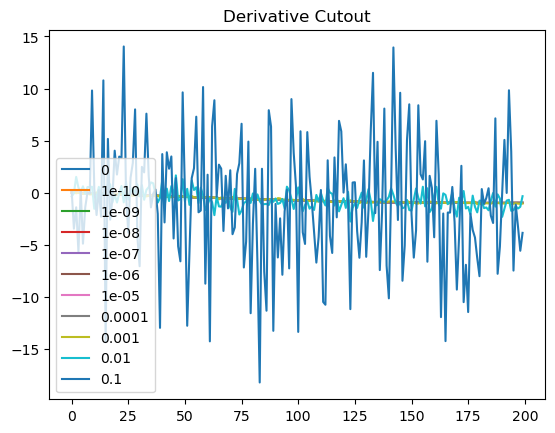

In [24]:
M=infinity_norm(uxxx)
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t  eps \t \t $max|ux-ux_noise|$ \t bound")
plt.title("Derivative Cutout")
order=2
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(u)))
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    plt.plot(ux_noise[0,:],label=str(target_noise))
    eps = infinity_norm(u_noise-u)
    bound = error_bound(eps,dx,M,order)
    diff = infinity_norm(ux-ux_noise)
    print(f"{target_noise} \t \t  {eps:.4f} \t {diff:.4f} \t \t {bound:.4f}")
plt.legend()
plt.show()

In [25]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print("Order \t Noise level \t  eps \t \t|ux-ux_noise| \t bound")
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        eps = infinity_norm(u_noise-u)
        bound = error_bound(eps,dx,M,order)
        diff = infinity_norm(ux-ux_noise)
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t \t  {eps:.3f} \t {diff:.4f} \t {bound:.4f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	  eps 	 	|ux-ux_noise| 	 bound
1
	 0	 	  0.000 	 0.0126 	 0.0126
	 1e-10	 	  0.000 	 0.0126 	 0.0126
	 1e-09	 	  0.000 	 0.0126 	 0.0126
	 1e-08	 	  0.000 	 0.0126 	 0.0126
	 1e-07	 	  0.000 	 0.0126 	 0.0126
	 1e-06	 	  0.000 	 0.0127 	 0.0128
	 1e-05	 	  0.000 	 0.0138 	 0.0149
	 0.0001	 	  0.000 	 0.0266 	 0.0355
	 0.001	 	  0.003 	 0.1762 	 0.2502
	 0.01	 	  0.030 	 1.8969 	 2.4158
2
	 0	 	  0.000 	 0.0002 	 0.0001
	 1e-10	 	  0.000 	 0.0002 	 0.0001
	 1e-09	 	  0.000 	 0.0002 	 0.0001
	 1e-08	 	  0.000 	 0.0002 	 0.0001
	 1e-07	 	  0.000 	 0.0002 	 0.0001
	 1e-06	 	  0.000 	 0.0004 	 0.0002
	 1e-05	 	  0.000 	 0.0022 	 0.0014
	 0.0001	 	  0.000 	 0.0192 	 0.0112
	 0.001	 	  0.003 	 0.3357 	 0.1265
	 0.01	 	  0.029 	 2.0489 	 1.1450
3
	 0	 	  0.000 	 0.0000 	 0.0000
	 1e-10	 	  0.000 	 0.0000 	 0.0000
	 1e-09	 	  0.000 	 0.0000 	 0.0000
	 1e-08	 	  0.000 	 0.0000 	 0.0000
	 1e-07	 	  0.000 	 0.0000 	 0.0001
	 1e-06	 	  0.000 	 0.0004 	 0.0008
	 1e-05	 	  0.000 

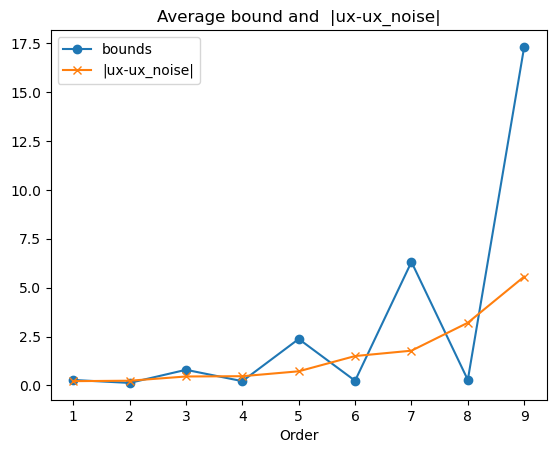

In [26]:
plt.title("Average bound and  |ux-ux_noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='|ux-ux_noise|')
plt.legend()

#### Without boundary values

In [27]:
M=infinity_norm(uxxx)
number_noise=8 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print("Order \t Noise level \t  eps \t \t|ux-ux_noise| \t bound")
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=True)._differentiate(u_noise, dx)
        row_mask = ~np.isnan(ux_noise).all(axis=1)
        col_mask = ~np.isnan(ux_noise).all(axis=0)
        eps = infinity_norm(u_noise[row_mask][:, col_mask]-u[row_mask][:, col_mask])
        bound = error_bound(eps,dx,M,order)
        diff = infinity_norm(ux[row_mask][:, col_mask]-ux_noise[row_mask][:, col_mask])
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t \t  {eps:.3f} \t {diff:.4f} \t {bound:.4f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	  eps 	 	|ux-ux_noise| 	 bound
1
	 0	 	  0.000 	 0.0126 	 0.0126
	 1e-10	 	  0.000 	 0.0126 	 0.0126
	 1e-09	 	  0.000 	 0.0126 	 0.0126
	 1e-08	 	  0.000 	 0.0126 	 0.0126
	 1e-07	 	  0.000 	 0.0126 	 0.0126
	 1e-06	 	  0.000 	 0.0127 	 0.0128
	 1e-05	 	  0.000 	 0.0138 	 0.0148
	 0.0001	 	  0.000 	 0.0249 	 0.0331
2
	 0	 	  0.000 	 0.0001 	 0.0001
	 1e-10	 	  0.000 	 0.0001 	 0.0001
	 1e-09	 	  0.000 	 0.0001 	 0.0001
	 1e-08	 	  0.000 	 0.0001 	 0.0001
	 1e-07	 	  0.000 	 0.0001 	 0.0001
	 1e-06	 	  0.000 	 0.0002 	 0.0002
	 1e-05	 	  0.000 	 0.0008 	 0.0012
	 0.0001	 	  0.000 	 0.0077 	 0.0116
3
	 0	 	  0.000 	 0.0000 	 0.0000
	 1e-10	 	  0.000 	 0.0000 	 0.0000
	 1e-09	 	  0.000 	 0.0000 	 0.0000
	 1e-08	 	  0.000 	 0.0000 	 0.0000
	 1e-07	 	  0.000 	 0.0000 	 0.0001
	 1e-06	 	  0.000 	 0.0001 	 0.0008
	 1e-05	 	  0.000 	 0.0014 	 0.0080
	 0.0001	 	  0.000 	 0.0134 	 0.0694
4
	 0	 	  0.000 	 0.0000 	 0.0000
	 1e-10	 	  0.000 	 0.0000 	 0.0000
	 1e-09	 	  0.000

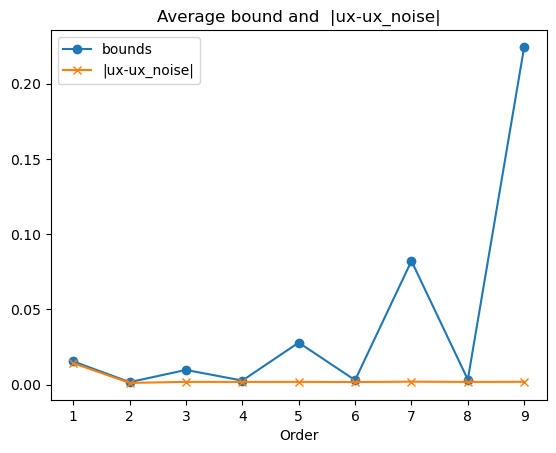

In [28]:
plt.title("Average bound and  |ux-ux_noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='|ux-ux_noise|')
plt.legend()

## Put everything together: Finite Differences and SVD

Let $\|g-\tilde{g}\|_F^2 = \sum_{i=1}^{n}\|u_{\alpha_i}-\tilde{u}_{\alpha_i}\|^2 < \|u-\tilde{u}\|^2+ \sum_{i=2}^n m\text{ errorbound}({\alpha_i},\epsilon)^2 =E $
$$| \frac{\tilde{\sigma}_1}{\tilde{\sigma}_n} - \frac{\sigma_1}{\sigma_n} | < \sqrt{(\frac{1}{\sigma_n}^2+\frac{\sigma_1}{\sigma_n^2}^2) E}$$

In [29]:
#Calculates E
#right now only for u and ux
"""
eps_two: ||u-u_noise||_2 two norm
eps_infty: ||u-u_noise||_infty infinity norm
h: dx for equispaced data
number_datapoints: number of total datapoints where u is evaluated
M: bound on nth derivative depending on the order
"""
def error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order):
    E = eps_two**2 + number_datapoints*error_bound(eps_infty,h,M,order)**2
    return E

"""
E: error bound on ||g-g_noise||_F^2 calculated in above function
sv_max: highest singular value on matrix without noise
sv_min: lowest singular value on matrix without noise
"""
def total_error_conditon(E,sv_max,sv_min):
    bound = np.sqrt(1/sv_min+(sv_max/sv_min**2)**2*E)
    return bound

In [30]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=0,L_x_end=1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()

u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)
"""
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u
"""
dx=x[1]-x[0]

In [31]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"Singular values of g: {sv_max,sv_min}")

Singular values of g: (95.83372706946885, 28.56390652509829)


Check $\sum_{i=1}^{n}\|u_{\alpha_i}-\tilde{u}_{\alpha_i}\|^2 < \sum_{i=1}^n m \text{ errorbound}({\alpha_i},\epsilon)^2  $

In [32]:
order=1
target_noise=1e-10
var = target_noise * np.sqrt(np.mean(np.square(u)))
noise = np.random.normal(0, var, size=u.shape)
u_noise = u + noise
eps_two = np.linalg.norm(u-u_noise)
eps_infty = infinity_norm(u-u_noise)
M=infinity_norm(uxxx)

ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
print(f"|g-g_noise|: {np.linalg.norm(true_g-g_noise):3.2e}")
print(f"Bound: {np.sqrt(E):3.3e}")

|g-g_noise|: 4.40e-01
Bound: 4.250e-01


Check $| \frac{\tilde{\sigma}_1}{\tilde{\sigma}_n} - \frac{\sigma_1}{\sigma_n} | < (\frac{1}{\sigma_n}^2+\frac{\sigma_1}{\sigma_n^2}^2) \sqrt{E}$

In [33]:
sv = svd(g_noise, compute_uv=False)
ratio = sv[0]/sv[-1]
print(f"|cond-cond_noise|: {np.abs(ratio-sv_max/sv_min):3.3e}")
print(f"Bound: {total_error_conditon(E,sv_max,sv_min):3.3e}")

|cond-cond_noise|: 1.428e-02
Bound: 1.937e-01


Do it for different orders and noise levels

In [34]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print("Order \t Noise level \t |g-g_noise| \t sqrt(E) \t|c-c_noise| \t Bound")
unorm2=np.sqrt(np.mean(np.square(u)))
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * unorm2
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        eps_two = np.linalg.norm(u-u_noise)
        eps_infty = infinity_norm(u-u_noise)
        
        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
        
        bound = total_error_conditon(E,sv_max,sv_min)
        diff = np.abs(ratio-sv_max/sv_min)
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t  \t {np.linalg.norm(true_g-g_noise):3.2e} \t {np.sqrt(E):3.2e} \t{diff:3.2e} \t{bound:3.2e}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound
1
	 0	  	 4.40e-01 	 4.25e-01 	1.43e-02 	1.94e-01
	 1e-10	  	 4.40e-01 	 4.25e-01 	1.43e-02 	1.94e-01
	 1e-09	  	 4.40e-01 	 4.25e-01 	1.43e-02 	1.94e-01
	 1e-08	  	 4.40e-01 	 4.26e-01 	1.43e-02 	1.94e-01
	 1e-07	  	 4.40e-01 	 4.32e-01 	1.43e-02 	1.94e-01
	 1e-06	  	 4.40e-01 	 4.92e-01 	1.43e-02 	1.96e-01
	 1e-05	  	 4.57e-01 	 1.07e+00 	1.43e-02 	2.25e-01
	 0.0001	  	 1.31e+00 	 7.12e+00 	1.43e-02 	8.57e-01
	 0.001	  	 1.24e+01 	 6.77e+01 	1.43e-02 	7.95e+00
	 0.01	  	 1.21e+02 	 7.31e+02 	1.43e-02 	8.59e+01
2
	 0	  	 8.63e-04 	 1.43e-03 	1.43e-02 	1.87e-01
	 1e-10	  	 8.63e-04 	 1.43e-03 	1.43e-02 	1.87e-01
	 1e-09	  	 8.63e-04 	 1.47e-03 	1.43e-02 	1.87e-01
	 1e-08	  	 8.65e-04 	 1.80e-03 	1.43e-02 	1.87e-01
	 1e-07	  	 1.08e-03 	 4.72e-03 	1.43e-02 	1.87e-01
	 1e-06	  	 6.84e-03 	 3.55e-02 	1.43e-02 	1.87e-01
	 1e-05	  	 6.82e-02 	 3.47e-01 	1.43e-02 	1.91e-01
	 0.0001	  	 6.82e-01 	 3.87e+00 	1.43e-02 	4.91e-01
	 

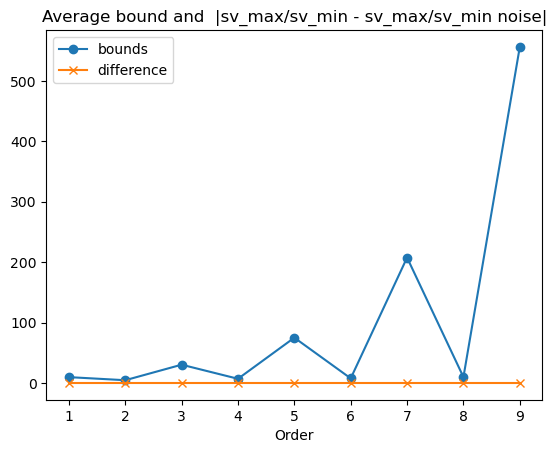

In [35]:
plt.title("Average bound and  |sv_max/sv_min - sv_max/sv_min noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='difference')
plt.legend()